In [1]:
import dgl.nn as dglnn
import math
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from collections import defaultdict
import gc
import torch.nn.init as init
from dgl.nn.functional import edge_softmax

In [2]:
data = pd.read_csv('../NF-BoT-IoT-v2.csv')

In [3]:
data = data.groupby(by='Attack').sample(frac=0.03, random_state=13)

In [4]:
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)
#data

In [8]:
data.drop(columns=['Label'],inplace = True)
data.rename(columns={"Attack": "label"},inplace = True)
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] =  
label = data.label
data.drop(columns=['label'],inplace = True)
scaler = StandardScaler()
data =  pd.concat([data, label], axis=1)

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,label
3848009,192.168.100.7:80,172.30.46.40:40341,6,7.0,44,1,180,2,22,18,...,0,5840,512,0,0,0,0,0,0,0
15450229,192.168.100.3:80,172.22.62.130:38871,6,7.0,44,1,320,3,22,18,...,0,29200,512,0,0,0,0,0,0,0
28461151,192.168.100.6:80,172.17.35.64:34243,6,7.0,40,1,280,2,22,20,...,0,0,512,0,0,0,0,0,0,0
9466343,192.168.100.3:80,172.17.69.33:53060,6,7.0,44,1,180,2,22,18,...,0,29200,512,0,0,0,0,0,0,0
15840846,192.168.100.3:80,172.22.233.14:43333,6,7.0,44,1,180,2,22,18,...,0,29200,512,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36039384,192.168.100.3:55548,172.26.223.127:4433,6,0.0,60,1,40,1,22,2,...,0,29200,0,0,0,0,0,0,0,4
18766993,192.168.100.3:54879,172.29.179.197:4433,6,0.0,60,1,40,1,22,2,...,0,29200,0,0,0,0,0,0,0,4
1569897,192.168.100.3:0,172.23.173.90:0,1,0.0,168,3,0,0,0,0,...,0,0,0,771,3,0,0,0,0,4
33750546,192.168.100.3:55338,172.25.168.149:4433,6,0.0,60,1,40,1,22,2,...,0,29200,0,0,0,0,0,0,0,4


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data,label, test_size=0.3, random_state=123,stratify= label)

In [10]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [11]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

X_train['h'] = X_train[ cols_to_norm ].values.tolist()


In [13]:
g_len = 35000
g_num = math.ceil(len(X_train)/g_len)

In [15]:
learning_rate =  0.0001
num = 20000
k1 = 3
tau = 5
num_epochs =  300
weight_decay = 0.00001

In [16]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [17]:
class GATlayer(nn.Module):
    def __init__(self, n_feat, e_feat, out_feat, num_heads):
        super(GATlayer,self).__init__()
        self.n_feat = n_feat
        self.e_feat = e_feat
        self.out_feat = out_feat
        self.num_heads = num_heads
        self.W_msg = nn.Linear(2 * n_feat + e_feat, out_feat)
        self.W = nn.Linear(2 * n_feat + e_feat, 2 * out_feat)
        self.a = nn.Parameter(torch.rand(size=(2 * out_feat  , 1)))
        self.reset_parameters()
        
    def reset_parameters(self):
        
        gain = math.sqrt(2)
        init.xavier_normal_(self.W.weight, gain=gain)
        init.xavier_normal_(self.a, gain=gain)
    
    def edge_attention(self, edges):        
        feat_cat = torch.cat([edges.src['h'], edges.dst['h'], edges.data['h']], dim=1)
        w_feat_cat = self.W(feat_cat)                   
        return {'e': F.leaky_relu(torch.matmul(w_feat_cat, self.a))}
    
    def message_func(self, edges):
        return {'h': self.W_msg(torch.cat([edges.src['h'], edges.dst['h'], edges.data['h']], dim=1)) , 'x': edges.data['x']}
  
    def reduce_func(self, nodes):
        h = (nodes.mailbox['x'] * nodes.mailbox['h']).sum(1)
        return {'h': h}
    
    def forward(self, g, n_feat, e_feat):
        with g.local_scope():
            g.ndata['h'] = n_feat
            g.edata['h'] = e_feat
            g.apply_edges(self.edge_attention)
            attention = edge_softmax(g, g.edata['e'])
            g.edata['x'] = attention
            g.update_all(self.message_func, self.reduce_func)
            g.ndata['h'] = F.relu(g.ndata['h'])
            feat = g.ndata['h'] 
            return feat
        
class MultiHeadGATLayer(nn.Module):
    def __init__(self, n_feat, e_feat, out_feat, num_heads):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATlayer(n_feat, e_feat, out_feat, num_heads))
        
    def forward(self,g, h, e_feat):
        out_feat = [attn_head(g, h, e_feat) for attn_head in self.heads]
        out_feat = torch.cat(out_feat,dim = 1).reshape(g.num_nodes(),len(self.heads), -1)
        return out_feat.mean(1)

class GAT(nn.Module):
    def __init__(self, in_dim, e_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer( in_dim, e_dim, 39, num_heads)
        
    def forward(self, g, h, e_feat):
        h = self.layer1(g, h, e_feat)
        g.ndata['h'] = h
        return h , g

In [18]:
class Genetation(torch.nn.Module):
    def __init__(self, in_feat, out_feat, num_heads, activation):
        super(Genetation, self).__init__()
        self.conv = GATConv(in_feat, out_feat, num_heads)
        self.activation = activation

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, g, feat):
        x = self.activation(self.conv(g, feat))
        g.ndata['h'] = x
        return x.mean(1) ,g

In [19]:
import random
def sub_sam(nodes, adj_lists, k):
    node_neighbor =  [ [] for i in range(nodes.shape[0])]
    node_neighbor_cen =  [ [] for i in range(nodes.shape[0])]
    node_centorr =  [[] for i in range(nodes.shape[0])]
    num_nei = 0

    for node in nodes:
        neighbors = set([int(node)])
        neighs = adj_lists[int(node)]
        node_centorr[num_nei] = [int(node)]
        current1 = adj_lists[int(node)]
        if len(neighs) >= k:
            neighs -= neighbors
            current1 = random.sample(neighs, k-1)

            node_neighbor[num_nei] = [neg_node for neg_node in current1]
            current1.append(int(node))
            node_neighbor_cen[num_nei] = [neg_node for neg_node in current1]
            num_nei += 1

        node_neighbor_cen[num_nei] = [neg_node for neg_node in current1]

    node_neighbor_cen = [neighbors for neighbors in node_neighbor_cen if neighbors]
    node_neighbor_cen  = node_neighbor_cen[:-1]
    return node_neighbor_cen

In [20]:
class Model(nn.Module):
    def __init__(self,  Encoder, gene, tau = 0.5):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.tau: float = tau
        self.ge = gene

    def forward(self, graph, node_feats, edge_feats) :
        z, g1 = self.encoder(graph,node_feats,edge_feats)
        z_g, g2 = self.ge(graph,z,edge_feats)
        return z, z_g, g1, g2
    
    def embed(self, graph, node_feats, edge_feats):
        z,_ = self.encoder(graph, node_feats, edge_feats)
        return z

    def loss(self, z1, z2, adj, sub_g1, g1, g2):
        loss = self.sub_loss_batch(z1, z2, adj, sub_g1, g1, g2)
        return loss

    def sub_loss_batch(self, z, z_g, adj, sub_g1, g1, g2):
        subz_s, sub_gene_s = self.subg_centor(z, z_g, sub_g1)

        num = th.randint(0, len(sub_g1)-1, [len(sub_g1),])
        if num[0] == 0:
            num[0] = 1
        for i in range(1, len(num)):
            if num[i] == i:
                num[i] -= 1
        subg2_s_n = subz_s[num] # disrupt
        sub_gene_s_n = sub_gene_s[num]
        input1 = th.cat((subz_s, subz_s, subz_s), dim=0)
        input2 = th.cat((sub_gene_s, subg2_s_n, sub_gene_s_n), dim=0)
        edges1, edges2 = self.edges_f(g1, g2, sub_g1, z, z_g)
        subg2_se = edges1[num]
        sub_gene_s_e = edges2[num]
        input1_edges = th.cat((edges1, edges1, edges1), dim=0)
        input2_edges = th.cat((edges2, subg2_se, sub_gene_s_e), dim=0)
        input1_edges = input1_edges.requires_grad_(True)
        input2_edges = input2_edges.requires_grad_(True)
        
        # adj
        subg1_adj = self.sub_adj(adj, sub_g1)
        input_adj = th.cat((subg1_adj, subg1_adj, subg1_adj), dim=0)
        
        lbl_1 = th.ones(len(sub_g1)).cuda()
        lbl_2 = th.zeros(len(sub_g1)*2).cuda()
        lbl = th.cat((lbl_1, lbl_2), 0).cuda()
        
        lbl_1_e = th.ones(len(edges2) ).cuda()
        lbl_2_e = th.zeros(len(edges2)* 2).cuda()
        lbl_e = th.cat((lbl_1_e, lbl_2_e), 0).cuda()
        
         # WD
        wd, T_wd = self.wd(input1, input2, self.tau)
        logits = th.exp(-wd / 0.01)
        loss1 = b_xent(th.squeeze(logits), lbl)
        print('loss1', loss1)
        
        # GWD
        gwd = self.gwd(input1.transpose(2,1), input2.transpose(2,1), T_wd, input_adj, self.tau)
        logits2 = th.exp(-gwd / 0.1)
        loss2 = b_xent(th.squeeze(logits2), lbl)
        print('loss2',loss2)
        

        wd, T_wd = self.wd(input1_edges, input2_edges, self.tau)
        logits3 = th.exp(-wd / 0.01)
        loss3 = b_xent(th.squeeze(logits3), lbl_e)
        print('loss3', loss3)


        loss = 0.5 * loss3 + 0.5 * loss2
        return loss
    
    def edges_f (self,g1,g2,sub_g1, z, z_g):
        edge_feat_1 = [[] for i in range(len(sub_g1))]
        edge_feat_2 = [[] for i in range(len(sub_g1))]
        sc = MLPPredictor(g1.edata['h'].shape[1],39).cuda()
        z_e = sc(g1, z)
        z_ge = sc(g2, z_g)
        for i in range(len(sub_g1)):
            cen_node = sub_g1[i][-1]
            dst = sub_g1[i][:-1]
            src_node_id = cen_node

            for j in dst:
                dst_node_id = j

                edge_indices = g1.edge_ids(src_node_id, dst_node_id,return_uv = True)

                edge_feature_1 = torch.Tensor(z_e[edge_indices[2]]).float().tolist()
                edge_feature_2 = torch.Tensor(z_ge[edge_indices[2]]).float().tolist()

                edge_feat_1.append(edge_feature_1)
                edge_feat_2.append(edge_feature_2)
                if len(edge_feat_1[-1]) == 2:
                    edge_feat_1[-1] = [edge_feat_1[-1][0]]
                    edge_feat_2[-1] = [edge_feat_2[-1][0]]
                
        edge_feat_1 = [neighbors for neighbors in edge_feat_1 if neighbors]
        edge_feat_2 = [neighbors for neighbors in edge_feat_2 if neighbors]
        edge_feat_1 = torch.Tensor(edge_feat_1)
        edge_feat_2 = torch.Tensor(edge_feat_2)
        edge_feat_1 = edge_feat_1.reshape(len(sub_g1),-1, 39)
        edge_feat_2 = edge_feat_2.reshape(len(sub_g1),-1, 39)
        return edge_feat_1, edge_feat_2
    
    def sub_adj(self, adj, sub_g1):
        subg1_adj = th.zeros(len(sub_g1), len(sub_g1[0]), len(sub_g1[0]))
        for i in range(len(sub_g1)):
            subg1_adj[i] = adj[sub_g1[i]].t()[sub_g1[i]]
        return subg1_adj


    def subg_centor(self, z, z_g, sub_g1):
        sub = [element for lis in sub_g1 for element in lis]
        subz = z[sub] 
        subg = z_g[sub]

        sub_s = subz.reshape(len(sub_g1), len(sub_g1[0]), -1)
        subg_s = subg.reshape(len(sub_g1), len(sub_g1[0]), -1)
        return sub_s, subg_s

    # WD
    def wd(self, x, y, tau):
        cos_distance = self.cost_matrix_batch(th.transpose(x, 2, 1), th.transpose(y, 2, 1), tau)
        cos_distance = cos_distance.transpose(1,2)

        beta = 0.1
        min_score = cos_distance.min()
        max_score = cos_distance.max()
        threshold = min_score + beta * (max_score - min_score)
        cos_dist = nn.functional.relu(cos_distance - threshold)
        
        wd, T_wd = self.OT_distance_batch(cos_dist, x.size(0), x.size(1), y.size(1), 40)
        return wd, T_wd

    def OT_distance_batch(self, C, bs, n, m, iteration=50):
        C = C.float().cuda()
        T = self.OT_batch(C, bs, n, m, iteration=iteration)
        temp = th.bmm(th.transpose(C,1,2), T)
        distance = self.batch_trace(temp, m, bs)
        return distance, T
    
    def OT_batch(self, C, bs, n, m, beta=0.5, iteration=50):
        sigma = th.ones(bs, int(m), 1).cuda()/float(m)
        T = th.ones(bs, n, m).cuda()
        A = th.exp(-C/beta).float().cuda()
        for t in range(iteration):
            Q = A * T
            for k in range(1):
                delta = 1 / (n * th.bmm(Q, sigma))
                a = th.bmm(th.transpose(Q,1,2), delta)
                sigma = 1 / (float(m) * a)
            T = delta * Q * sigma.transpose(2,1)
        return T

    def cost_matrix_batch(self, x, y, tau=0.5):
        bs = list(x.size())[0]
        D = x.size(1)
        assert(x.size(1)==y.size(1))
        x = x.contiguous().view(bs, D, -1)
        x = x.div(th.norm(x, p=2, dim=1, keepdim=True) + 1e-12)
        y = y.div(th.norm(y, p=2, dim=1, keepdim=True) + 1e-12)
        
        cos_dis = th.bmm(th.transpose(x, 1, 2), y)
        cos_dis = th.exp(- cos_dis / tau)
        return cos_dis.transpose(2,1)

    def batch_trace(self, input_matrix, n, bs):
        a = th.eye(n).cuda().unsqueeze(0).repeat(bs, 1, 1)
        b = a * input_matrix
        return th.sum(th.sum(b,-1),-1).unsqueeze(1)
    
    
    # GWD
    def gwd(self, X, Y, T_wd, input_adj, tau, lamda=1e-1, iteration=5, OT_iteration=20):
        m = X.size(2)
        n = Y.size(2)
        bs = X.size(0)
        p = (th.ones(bs, m, 1)/m).cuda()
        q = (th.ones(bs, n, 1)/n).cuda()
        return self.GW_distance(X, Y, p, q, T_wd, input_adj, tau, lamda=lamda, iteration=iteration, OT_iteration=OT_iteration)

    def GW_distance(self, X, Y, p, q, T_wd, input_adj, tau, lamda=0.5, iteration=5, OT_iteration=20):
        cos_dis = th.exp(- input_adj / tau).cuda() 
        beta = 0.1
        min_score = cos_dis.min()
        max_score = cos_dis.max()
        threshold = min_score + beta * (max_score - min_score)
        res = cos_dis - threshold
        Cs = nn.functional.relu(res.transpose(2,1))

        Ct = self.cos_batch(Y, Y, tau).float().cuda()
        bs = Cs.size(0)
        m = Ct.size(2)
        n = Cs.size(2)
        T, Cst = self.GW_batch(Cs, Ct, bs, n, m, p, q, beta=lamda, iteration=iteration, OT_iteration=OT_iteration)
        temp = th.bmm(th.transpose(Cst,1,2), T_wd)
        distance = self.batch_trace(temp, m, bs)
        return distance

    def GW_batch(self, Cs, Ct, bs, n, m, p, q, beta=0.5, iteration=5, OT_iteration=20):
        one_m = th.ones(bs, m, 1).float().cuda()
        one_n = th.ones(bs, n, 1).float().cuda()

        Cst = th.bmm(th.bmm(Cs**2, p), th.transpose(one_m, 1, 2)) + \
            th.bmm(one_n, th.bmm(th.transpose(q,1,2), th.transpose(Ct**2, 1, 2)))
        gamma = th.bmm(p, q.transpose(2,1))
        for i in range(iteration):
            C_gamma = Cst - 2 * th.bmm(th.bmm(Cs, gamma), th.transpose(Ct, 1, 2))
            gamma = self.OT_batch(C_gamma, bs, n, m, beta=beta, iteration=OT_iteration)
        Cgamma = Cst - 2 * th.bmm(th.bmm(Cs, gamma), th.transpose(Ct, 1, 2))
        return gamma.detach(), Cgamma

    def cos_batch(self, x, y, tau):
        bs = x.size(0)
        D = x.size(1)
        assert(x.size(1)==y.size(1))
        x = x.contiguous().view(bs, D, -1)
        x = x.div(th.norm(x, p=2, dim=1, keepdim=True) + 1e-12)
        y = y.div(th.norm(y, p=2, dim=1, keepdim=True) + 1e-12)
        cos_dis = th.bmm(th.transpose(x,1,2), y)
        cos_dis = th.exp(- cos_dis / tau).transpose(1,2)
        
        beta = 0.1
        min_score = cos_dis.min()
        max_score = cos_dis.max()
        threshold = min_score + beta * (max_score - min_score)
        res = cos_dis - threshold
        return nn.functional.relu(res.transpose(2,1))

In [21]:
def train(model, g,node_feats,edge_feats, adj, node_neighbor_cen):
    model.train()
    optimizer.zero_grad()
    z1, z2, g1, g2 = model(g, node_feats, edge_feats)
    loss = model.loss(z1, z2, adj, node_neighbor_cen, g1, g2)
    loss.backward(retain_graph=True)
    optimizer.step()

    return loss.item()

In [22]:
%%time
graph = []
for i in range(g_num):
    G = X_train[ i*g_len: (i+1)* g_len ]
    G = nx.from_pandas_edgelist(G, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
    G = G.to_directed()
    G = from_networkx(G,edge_attrs=['h','label'] )
    graph.append(G)

CPU times: user 45.6 s, sys: 1.4 s, total: 47 s
Wall time: 47 s


In [26]:
if graph[-1].num_nodes() < num :
    graph = graph[:-1]

In [28]:
n_dim = G.edata['h'].shape[1]
e_dim = G.edata['h'].shape[1]
out_dim = G.edata['h'].shape[1]
num_heads = 3
num_hidden = G.edata['h'].shape[1]
activation = F.relu

In [29]:
Encoder =  GAT(n_dim, e_dim, out_dim , num_heads).cuda()
gene = GAT(n_dim, e_dim, out_dim , num_heads)
model = Model(Encoder, gene).cuda()
optimizer = th.optim.Adam(model.parameters())

In [30]:
b_xent = nn.BCEWithLogitsLoss()
node_neighbor = {}
best = 1e9
best_t = 0
bestacc = 0

In [32]:
%%time
import time
print(time.localtime())

for i , g in enumerate(graph):
    g.ndata['h'] = th.ones(g.num_nodes(), g.edata['h'].shape[1])
    adj = sp.coo_matrix((np.ones(g.num_edges()), (g.edges()[0], g.edges()[1]) ), 
                                        shape=( g.num_nodes(),  g.num_nodes()), dtype=np.float32).toarray()
    adj = th.from_numpy(adj).cuda()
    adj_lists = defaultdict(set)
    g1 = g
    for x in range(g1.num_edges()):  
        adj_lists[g1.edges()[0][x].item()].add(g1.edges()[1][x].item())
    g = g.to('cuda:0')
    node_feats = g.ndata['h']
    edge_feats = g.edata['h']
    
    for epoch in range(1, num_epochs + 1):
        nodes_batch = th.randint(0, g.num_nodes(), (num, )) 
        node_neighbor_cen = sub_sam(nodes_batch, adj_lists, k1)
        print('node_neighbor_cen',len(node_neighbor_cen))
        loss = train(model, g, node_feats, edge_feats, adj, node_neighbor_cen)
    del adj,g
    gc.collect()
    th.cuda.empty_cache()
    th.cuda.empty_cache()
    th.cuda.empty_cache()
    th.cuda.empty_cache()
    th.cuda.empty_cache()
    print('#################################')
    print(i)
    print('#################################')

print(time.localtime())
    


time.struct_time(tm_year=2023, tm_mon=12, tm_mday=21, tm_hour=12, tm_min=17, tm_sec=51, tm_wday=3, tm_yday=355, tm_isdst=0)


/tmp/ipykernel_3535/429784891.py:16: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  current1 = random.sample(neighs, k-1)


node_neighbor_cen 45
loss1 tensor(0.7922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6993, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8240, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 36
loss1 tensor(0.7865, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6991, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8158, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.7992, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6996, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8903, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 30
loss1 tensor(0.8079, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 40
loss1 tensor(0.8081, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6979, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8173, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8366, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6985, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8824, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8182, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6986, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8316, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 36
loss1 tensor(0.8456, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6962, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8741, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8404, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6967, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8633, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8137, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6948, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8735, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8189, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 46
loss1 tensor(0.8498, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8230, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8065, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6965, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8525, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8308, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8250, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 32
loss1 tensor(0.8261, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 51
loss1 tensor(0.8692, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6957, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8725, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 33
loss1 tensor(0.8700, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6957, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8783, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8591, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6937, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8753, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8775, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 38
loss1 tensor(0.8436, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6971, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7766, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8386, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6963, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8737, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8732, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6960, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8387, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8679, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 49
loss1 tensor(0.8682, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6952, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8645, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8626, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6958, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8580, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8527, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6947, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8918, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8543, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 48
loss1 tensor(0.8676, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8819, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8698, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6956, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7653, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8844, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6971, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8998, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8434, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 50
loss1 tensor(0.8465, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8968, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8603, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6937, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8476, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8891, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8678, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 49
loss1 tensor(0.8673, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6955, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8908, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 35
loss1 tensor(0.8822, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6965, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8986, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8701, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8796, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8828, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 50
loss1 tensor(0.8534, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6955, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8623, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8683, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6966, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8152, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8606, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8546, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8656, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 45
loss1 tensor(0.8438, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8839, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8681, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8546, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8407, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6960, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8519, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8530, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 51
loss1 tensor(0.8148, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8669, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8226, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8842, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8417, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6958, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8899, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8485, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 53
loss1 tensor(0.8644, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8125, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6964, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8178, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6956, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8326, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 63
loss1 tensor(0.8156, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 40
loss1 tensor(0.8663, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6966, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8671, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 59
loss1 tensor(0.8780, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8454, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8852, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6934, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8680, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8886, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 50
loss1 tensor(0.8537, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8569, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8609, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6934, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8713, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8769, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8516, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8720, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 41
loss1 tensor(0.8045, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8654, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 70
loss1 tensor(0.8456, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7640, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8405, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6966, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8451, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8139, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 41
loss1 tensor(0.8411, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8276, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 29
loss1 tensor(0.8848, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6965, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8688, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 58
loss1 tensor(0.8854, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6971, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8695, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 52
loss1 tensor(0.8870, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8869, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8862, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6961, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8963, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8551, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6961, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8558, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8541, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 58
loss1 tensor(0.8547, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6970, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8626, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8520, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6948, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8462, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6955, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8734, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8294, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 50
loss1 tensor(0.8470, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8462, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8476, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6968, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8677, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 62
loss1 tensor(0.8237, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8423, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8359, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 53
loss1 tensor(0.8110, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6967, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8128, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8523, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 59
loss1 tensor(0.8430, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6959, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8420, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8354, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 39
loss1 tensor(0.8415, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6938, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8734, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 32
loss1 tensor(0.8540, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6943, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8312, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 35
loss1 tensor(0.8534, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6940, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8714, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8462, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 44
loss1 tensor(0.8445, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6960, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8605, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 28
loss1 tensor(0.8752, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6917, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8905, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 34
loss1 tensor(0.8611, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6972, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8787, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8374, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8814, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6938, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8184, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8459, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6973, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8724, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8717, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8542, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8907, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 38
loss1 tensor(0.8393, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6987, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8313, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.7856, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6974, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8619, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8517, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8812, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8299, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8630, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6981, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8602, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8252, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6963, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7994, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8270, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6971, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8204, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 30
loss1 tensor(0.8457, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6992, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8547, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8648, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8673, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8807, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6969, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8644, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8727, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 34
loss1 tensor(0.8379, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6940, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8394, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 35
loss1 tensor(0.8297, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6970, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8563, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 36
loss1 tensor(0.8539, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6940, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8711, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 29
loss1 tensor(0.8081, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 29
loss1 tensor(0.8668, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8612, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8784, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8280, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6978, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8470, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8308, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 39
loss1 tensor(0.8527, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6963, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8790, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8509, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8891, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8568, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6940, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8890, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8479, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8621, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8455, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8841, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6959, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8821, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8758, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6955, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8159, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8683, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 36
loss1 tensor(0.8913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8966, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8666, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8627, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 36
loss1 tensor(0.8895, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8907, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 54
loss1 tensor(0.7655, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6971, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.7958, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8901, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 31
loss1 tensor(0.7983, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6964, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8008, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 34
loss1 tensor(0.8535, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6940, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8822, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8620, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9048, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8606, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8973, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8636, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 39
loss1 tensor(0.7732, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6938, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7745, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8192, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8966, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8042, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6948, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8789, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 36
loss1 tensor(0.8040, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 32
loss1 tensor(0.8345, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6940, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8461, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8305, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6941, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9020, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8132, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7824, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8108, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 45
loss1 tensor(0.8404, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8749, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8215, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8239, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8508, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6947, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8186, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8319, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 43
loss1 tensor(0.7681, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6948, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7813, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.7803, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8079, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.7952, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8724, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.7790, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 34
loss1 tensor(0.8573, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6972, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8965, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 36
loss1 tensor(0.8455, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6956, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8721, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8589, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6938, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8933, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8509, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 33
loss1 tensor(0.8267, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8143, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8076, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6941, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7878, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8314, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6937, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8287, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8607, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8901, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8403, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6916, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8711, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8516, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8959, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8479, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 39
loss1 tensor(0.8259, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6957, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8624, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.7885, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6958, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8477, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.7990, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7822, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8069, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 48
loss1 tensor(0.8022, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8408, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8275, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6918, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8778, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8153, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6948, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8876, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8302, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8789, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8686, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 58
loss1 tensor(0.8869, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6933, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8740, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 63
loss1 tensor(0.8816, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8735, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8554, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8488, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8484, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8028, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8867, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8357, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6917, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8076, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8317, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 51
loss1 tensor(0.8678, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8962, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8593, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8863, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8579, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8997, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8504, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 46
loss1 tensor(0.8789, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8997, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8722, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6930, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8644, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 64
loss1 tensor(0.8559, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8623, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8695, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8649, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6906, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8824, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8635, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6896, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8821, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8853, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6933, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8817, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8895, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 40
loss1 tensor(0.8807, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6903, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8628, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6930, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8496, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8803, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8747, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 44
loss1 tensor(0.8559, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8411, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8783, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8692, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7872, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8472, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8373, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6941, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8916, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8625, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8792, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8385, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8564, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8616, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 45
loss1 tensor(0.8578, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6920, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8833, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8666, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6916, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8481, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8617, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6937, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8878, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8621, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 43
loss1 tensor(0.8489, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8719, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 26
loss1 tensor(0.8735, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6924, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8643, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6958, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8750, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8618, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 36
loss1 tensor(0.8659, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8826, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8698, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6938, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9054, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8694, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6924, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8678, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8606, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 49
loss1 tensor(0.8754, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8874, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 34
loss1 tensor(0.8782, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6910, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8195, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8710, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8809, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8778, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8731, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6901, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8895, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8700, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6933, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8151, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 59
loss1 tensor(0.8792, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6948, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8795, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8762, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 47
loss1 tensor(0.8889, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6916, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8562, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8940, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8408, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8521, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8533, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 36
loss1 tensor(0.8890, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 49
loss1 tensor(0.8306, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8767, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 34
loss1 tensor(0.8195, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6924, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8691, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8568, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8956, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8320, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8750, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6956, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8952, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8557, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8746, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 34
loss1 tensor(0.8760, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8938, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8730, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 38
loss1 tensor(0.8761, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8825, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8602, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 29
loss1 tensor(0.8635, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6899, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8647, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8772, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8675, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8705, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 35
loss1 tensor(0.8927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8696, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8849, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6896, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8848, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8807, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 37
loss1 tensor(0.8858, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8832, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8880, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8557, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8844, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 34
loss1 tensor(0.8278, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 62
loss1 tensor(0.8386, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6952, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8638, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 36
loss1 tensor(0.8338, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8803, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8307, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6937, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8137, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8225, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8245, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7719, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8315, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8810, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8403, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6924, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8886, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8322, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 48
loss1 tensor(0.8449, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8110, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8498, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9058, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8603, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6918, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8700, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 36
loss1 tensor(0.8229, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8303, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6943, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8716, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8178, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7751, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8119, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6938, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8768, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8334, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 45
loss1 tensor(0.8445, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8803, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8256, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8440, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8401, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6896, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8738, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8370, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 45
loss1 tensor(0.8241, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8460, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8110, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8958, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.7818, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6930, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8831, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 63
loss1 tensor(0.8172, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 44
loss1 tensor(0.8417, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6899, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8615, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8396, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6898, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7966, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 60
loss1 tensor(0.8323, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8746, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8396, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 38
loss1 tensor(0.8606, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8649, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8300, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8727, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8411, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8741, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8505, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 38
loss1 tensor(0.8449, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8786, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8537, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8463, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8661, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8971, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 31
loss1 tensor(0.8412, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 49
loss1 tensor(0.7992, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6916, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8650, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8218, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8880, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8291, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6908, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8227, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 53
loss1 tensor(0.8448, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8382, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8375, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6956, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8222, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8253, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6887, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8957, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8516, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 48
loss1 tensor(0.8489, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8668, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8384, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6915, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8566, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8491, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8386, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8589, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8747, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8708, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 62
loss1 tensor(0.8735, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6948, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8754, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8620, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 53
loss1 tensor(0.7704, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6948, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8112, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.7751, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8112, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.7719, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6934, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8171, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8138, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 46
loss1 tensor(0.8229, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8890, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8456, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8611, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8580, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6905, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8117, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8518, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 46
loss1 tensor(0.8650, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8875, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8552, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6892, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8639, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8638, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6900, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8192, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8653, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 45
loss1 tensor(0.8551, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6934, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8958, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8491, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8800, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8429, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8647, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8192, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 46
loss1 tensor(0.8768, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6905, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8136, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8574, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6930, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8456, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 67
loss1 tensor(0.8479, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6938, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8674, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8561, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 59
loss1 tensor(0.8534, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8769, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8582, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7969, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8496, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8323, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8581, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 56
loss1 tensor(0.8653, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7915, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8614, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8843, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8595, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6924, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8821, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8552, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 65
loss1 tensor(0.8711, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6941, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8835, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8597, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6924, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8283, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 36
loss1 tensor(0.8439, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8088, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8807, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 48
loss1 tensor(0.8559, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6897, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8975, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8529, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6918, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8354, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 35
loss1 tensor(0.8494, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6893, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8719, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8615, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 44
loss1 tensor(0.8594, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8920, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8781, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8957, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8639, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8847, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8818, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 34
loss1 tensor(0.8764, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6938, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8791, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8603, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8835, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8808, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 44
loss1 tensor(0.8682, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6894, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8867, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8669, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8977, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8800, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6930, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8708, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 50
loss1 tensor(0.8586, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6909, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8912, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8622, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6889, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8822, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8738, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8499, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8562, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 44
loss1 tensor(0.8852, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8905, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8794, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6920, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8873, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8794, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8856, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8956, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 40
loss1 tensor(0.8821, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8899, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8795, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6934, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8824, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 35
loss1 tensor(0.8695, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8766, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8382, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8835, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 35
loss1 tensor(0.8499, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6902, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8644, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8688, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 38
loss1 tensor(0.8500, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6920, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8618, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8866, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6880, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 32
loss1 tensor(0.8802, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6895, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8909, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8744, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 37
loss1 tensor(0.8780, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8776, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8907, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6988, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8917, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 21
loss1 tensor(0.8814, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8982, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 36
loss1 tensor(0.8983, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6900, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8979, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8841, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8905, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8968, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8888, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8737, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6930, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8843, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8688, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
#################################
8
#################################
node_neighbor_cen 41
loss1 tensor(0.8692, 

node_neighbor_cen 47
loss1 tensor(0.8312, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8602, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6940, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8510, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8335, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6930, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8853, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8689, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss3 tensor(0.8531, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8541, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6933, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8201, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8260, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6901, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8248, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6924, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7877, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 50
loss1 tensor(0.8477, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6908, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8683, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8563, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8875, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8579, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8540, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8752, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8714, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8529, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8825, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8643, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8656, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8712, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 49
loss1 tensor(0.8633, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8976, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8705, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6908, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8977, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8602, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6912, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8805, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 46
loss1 tensor(0.8301, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8498, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 33
loss1 tensor(0.8660, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8596, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8719, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6902, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8436, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 49
loss1 tensor(0.8621, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6883, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8682, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8243, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8863, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8657, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6934, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8740, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8571, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 40
loss1 tensor(0.8534, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8723, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8398, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6910, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8686, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 59
loss1 tensor(0.8435, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6878, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8401, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 44
loss1 tensor(0.8674, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8682, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8896, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6898, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8969, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8937, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6912, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8887, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 49
loss1 tensor(0.8364, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8591, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8562, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6901, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8887, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8327, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8843, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8147, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 35
loss1 tensor(0.8528, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8821, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8641, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6941, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8776, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8598, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6909, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8320, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8692, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 40
loss1 tensor(0.8993, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 33
loss1 tensor(0.8903, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6969, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8973, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6918, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8899, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 56
loss1 tensor(0.8869, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8696, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8719, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6940, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8738, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 36
loss1 tensor(0.8893, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6959, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8848, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8838, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 41
loss1 tensor(0.8647, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6988, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8875, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8769, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6910, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8803, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6915, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8966, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8592, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 58
loss1 tensor(0.8294, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8518, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8324, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6948, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8084, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8172, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6933, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7735, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8334, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 40
loss1 tensor(0.8411, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6959, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8968, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8270, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6940, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7974, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 36
loss1 tensor(0.8222, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6952, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8808, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8330, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8197, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8459, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8392, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7965, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8161, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8576, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8266, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

loss1 tensor(0.8151, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6910, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7659, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8216, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8115, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 30
loss1 tensor(0.8500, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6941, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8777, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8387, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 33
loss1 tensor(0.8725, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6976, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8167, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 36
loss1 tensor(0.8814, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8882, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6908, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8650, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8905, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8697, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8858, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8707, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6948, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8586, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6933, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8998, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8715, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8668, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6938, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7628, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8631, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8140, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 33
loss1 tensor(0.8527, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8536, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8621, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 44
loss1 tensor(0.8704, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8987, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 61
loss1 tensor(0.8703, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8386, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8732, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8025, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 79
loss1 tensor(0.8740, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 41
loss1 tensor(0.8133, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8582, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8559, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8372, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8682, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8975, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 63
loss1 tensor(0.8580, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 48
loss1 tensor(0.8669, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8232, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8748, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6920, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8781, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8712, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8816, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8621, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6934, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8740, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8636, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8462, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8628, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6973, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7924, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8461, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 66
loss1 tensor(0.8455, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6952, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8790, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8754, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6959, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8550, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8712, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 59
loss1 tensor(0.8665, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 50
loss1 tensor(0.8401, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8782, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 63
loss1 tensor(0.8476, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8450, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 63
loss1 tensor(0.8564, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8965, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8401, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss3 tensor(0.8855, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 58
loss1 tensor(0.8205, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6933, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8438, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 60
loss1 tensor(0.8372, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6943, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8724, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8198, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6930, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7996, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 52
loss1 tensor(0.8395, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8639, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8241, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6920, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7772, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8278, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8304, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8228, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 48
loss1 tensor(0.8332, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6889, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8527, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8296, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8356, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8376, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6917, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 61
loss1 tensor(0.8410, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8493, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8186, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 66
loss1 tensor(0.8484, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8827, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8503, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6959, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8711, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 61
loss1 tensor(0.8459, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 35
loss1 tensor(0.8707, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6895, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8760, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8500, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8978, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 36
loss1 tensor(0.8675, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 46
loss1 tensor(0.8309, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8128, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8542, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8882, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8607, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8456, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 48
loss1 tensor(0.8463, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6941, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8743, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8414, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6900, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8904, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8474, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8891, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8509, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 48
loss1 tensor(0.8692, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8828, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8672, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6967, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8672, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 60
loss1 tensor(0.8553, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6903, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8810, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8759, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 53
loss1 tensor(0.8513, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6960, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8675, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8912, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8682, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8993, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 34
loss1 tensor(0.8582, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8661, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8511, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8864, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8553, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8952, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8343, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8320, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8587, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8613, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8958, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8357, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8822, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8684, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8734, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8305, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8648, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8379, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8685, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6968, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8611, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8741, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 48
loss1 tensor(0.8712, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6909, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 35
loss1 tensor(0.8739, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6957, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8470, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8585, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8318, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8847, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 51
loss1 tensor(0.8707, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8619, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6962, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8482, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 34
loss1 tensor(0.8714, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6896, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8796, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8587, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 39
loss1 tensor(0.8713, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6896, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8584, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8688, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6917, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8890, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8744, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8723, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 51
loss1 tensor(0.8891, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6901, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8622, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8904, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8812, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6910, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8789, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 53
loss1 tensor(0.8926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6972, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6961, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6947, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 40
loss1 tensor(0.8964, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8995, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 30
loss1 tensor(0.8903, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 59
loss1 tensor(0.8937, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8920, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8840, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8209, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8187, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8878, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6952, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8937, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8915, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 54
loss1 tensor(0.8671, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6963, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8830, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8671, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8798, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6943, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8714, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8734, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 43
loss1 tensor(0.8724, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6947, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8790, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8709, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8867, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8796, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6956, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8895, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8778, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 34
loss1 tensor(0.8394, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7504, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8733, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8697, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6937, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8782, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8786, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8993, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6940, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8964, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6947, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8789, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8904, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

loss1 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6900, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8811, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6968, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8997, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8984, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8964, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 46
loss1 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8998, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8967, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6900, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8917, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
#################################
13
#################################
node_neighbor_cen 48
loss1 tensor(0.8941, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6948, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8981, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56

node_neighbor_cen 59
loss1 tensor(0.8923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6952, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8772, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6958, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8816, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8907, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8802, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 46
loss1 tensor(0.8936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8589, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6912, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8988, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8785, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8805, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 46
loss1 tensor(0.8856, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6920, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8962, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8755, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8894, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8928, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 59
loss1 tensor(0.8640, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6957, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8765, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8360, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8524, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8716, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6908, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8500, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8784, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss2 tensor(0.6944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8045, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8780, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6943, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8252, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8703, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8899, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8340, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6962, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 51
loss1 tensor(0.8448, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6959, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8796, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8620, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8792, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8798, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8993, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8479, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 41
loss1 tensor(0.8683, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6916, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8452, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8674, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6933, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8676, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8635, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6924, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8675, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 66
loss1 tensor(0.8463, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6906, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8239, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8603, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8868, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8651, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6915, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8771, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8593, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8756, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6893, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8626, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6887, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8154, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8654, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8987, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8721, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 46
loss1 tensor(0.8698, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8779, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8610, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6905, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8838, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8681, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6902, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8958, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8410, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 45
loss1 tensor(0.8680, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 60
loss1 tensor(0.8847, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6924, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8883, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8617, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6907, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7955, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8823, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 65
loss1 tensor(0.8726, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6915, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9068, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 64
loss1 tensor(0.8608, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8829, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8492, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8613, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 39
loss1 tensor(0.8726, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8965, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8724, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8760, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8761, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8837, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8620, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 59
loss1 tensor(0.8561, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6896, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8731, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8679, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8941, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8655, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6909, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8774, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8563, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 49
loss1 tensor(0.8786, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8934, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 59
loss1 tensor(0.8659, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8868, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8406, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6888, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8286, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8838, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 48
loss1 tensor(0.8756, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8645, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8655, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6956, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8397, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8711, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6908, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8693, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 56
loss1 tensor(0.8838, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6899, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8484, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8663, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8833, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8734, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6956, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8856, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 62
loss1 tensor(0.8850, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 49
loss1 tensor(0.8800, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8842, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6961, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8829, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8872, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 62
loss1 tensor(0.8836, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8894, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6908, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8301, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8534, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6917, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8993, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 69
loss1 tensor(0.8794, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6918, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8991, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8950, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 57
loss1 tensor(0.8932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8696, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8844, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6957, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8645, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 64
loss1 tensor(0.8671, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6893, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8890, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8754, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 53
loss1 tensor(0.8802, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8852, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8818, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6896, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8986, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 35
loss1 tensor(0.8754, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6874, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8979, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 58
loss1 tensor(0.8737, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 39
loss1 tensor(0.8681, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8840, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8532, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6964, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8497, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8737, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8806, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8769, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 37
loss1 tensor(0.8563, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8676, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8531, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8549, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8885, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8978, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8659, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 36
loss1 tensor(0.8928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6918, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8968, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6948, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8610, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6908, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8619, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8781, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 52
loss1 tensor(0.8643, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6960, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8842, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8805, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8963, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8870, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8693, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8779, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6913, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8912, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8717, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8788, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8598, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6963, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8882, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8772, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 61
loss1 tensor(0.8607, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8587, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8715, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8691, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8784, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8875, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8675, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 44
loss1 tensor(0.8711, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6864, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8920, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 35
loss1 tensor(0.8826, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8729, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8685, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6895, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8893, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8720, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 55
loss1 tensor(0.8625, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6890, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8321, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8594, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6894, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8702, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8748, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 51
loss1 tensor(0.8900, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8715, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 29
loss1 tensor(0.8799, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6930, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8291, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8794, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6918, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8633, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8797, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8844, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6915, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8620, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8871, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6897, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8702, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8783, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6915, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8905, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8826, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 48
loss1 tensor(0.8886, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8792, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6897, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8831, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6908, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8778, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8838, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 57
loss1 tensor(0.8745, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8938, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8701, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6934, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8834, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8582, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8480, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8603, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 45
loss1 tensor(0.8519, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6907, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8586, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8691, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6922, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8808, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8711, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8867, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8708, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 41
loss1 tensor(0.8753, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6895, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8787, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8767, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8677, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6905, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8803, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8779, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8828, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8753, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8545, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8826, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8959, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6932, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8484, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8652, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 56
loss1 tensor(0.8578, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6930, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8753, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 32
loss1 tensor(0.8752, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6947, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8495, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6923, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8659, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8844, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 37
loss1 tensor(0.8491, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8780, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8605, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8813, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8735, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6888, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8684, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 48
loss1 tensor(0.8613, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8726, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8832, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6918, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8893, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 62
loss1 tensor(0.8659, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8828, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8700, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 43
loss1 tensor(0.8765, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6918, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8487, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8542, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6924, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8634, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8877, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6899, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8765, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 55
loss1 tensor(0.8781, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6935, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8672, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8750, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8732, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8958, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8732, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 38
loss1 tensor(0.8633, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6943, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8555, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8888, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6924, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8349, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6920, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8978, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8908, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 40
loss1 tensor(0.8769, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8102, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8861, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8557, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6962, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8725, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8790, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 40
loss1 tensor(0.8863, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8888, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8975, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6917, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8987, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8843, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8851, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8756, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8695, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8753, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8718, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6915, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8787, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 32
loss1 tensor(0.8837, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8551, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 40
loss1 tensor(0.8994, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 50
loss1 tensor(0.8723, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7035, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8146, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7020, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8905, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8499, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8804, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8833, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8857, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8981, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 31
loss1 tensor(0.8734, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6997, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8975, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8824, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 52
loss1 tensor(0.8962, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7013, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9000, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8601, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6985, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9030, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8891, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7000, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8907, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8827, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 53
loss1 tensor(0.8888, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8891, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7009, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8831, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8803, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8771, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8784, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 38
loss1 tensor(0.8883, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6986, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8818, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6993, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8862, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8793, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6996, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8380, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8890, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 45
loss1 tensor(0.8784, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6997, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8432, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8742, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6991, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8403, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8759, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6997, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8519, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8831, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 54
loss1 tensor(0.8934, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7000, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8961, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8780, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7000, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8837, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8982, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8637, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8986, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 37
loss1 tensor(0.8909, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8799, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6993, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8795, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 50
loss1 tensor(0.8666, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6995, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8517, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8668, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 43
loss1 tensor(0.8956, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6990, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8679, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8813, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6989, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8886, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 57
loss1 tensor(0.8840, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6996, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8900, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8968, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8857, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8679, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6995, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9042, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8841, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6992, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9036, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8828, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 47
loss1 tensor(0.8829, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6991, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8783, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8900, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6992, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8554, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8847, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6987, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8185, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8819, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 53
loss1 tensor(0.8897, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6990, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9168, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8865, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6987, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8881, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8771, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6986, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8125, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8716, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8890, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6994, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8676, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8766, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6990, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8972, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 59
loss1 tensor(0.8800, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6991, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8794, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 45
loss1 tensor(0.8944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6993, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9291, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8795, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6993, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8431, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8859, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6994, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8866, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 56
loss1 tensor(0.8795, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6994, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8977, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6990, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8470, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8863, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6986, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8237, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8936, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 54
loss1 tensor(0.8830, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6984, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8781, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8540, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6996, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8969, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8920, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6998, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8115, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8782, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 39
loss1 tensor(0.8914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6994, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6992, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8738, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6996, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9054, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8840, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 46
loss1 tensor(0.8727, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6986, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8894, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 39
loss1 tensor(0.8951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6996, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8930, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8796, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6981, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8872, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 62
loss1 tensor(0.8772, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 33
loss1 tensor(0.8795, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6980, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8461, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8699, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6990, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8244, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 52
loss1 tensor(0.8772, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6992, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8209, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8687, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 38
loss1 tensor(0.8767, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6992, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8735, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6978, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 43
loss1 tensor(0.8677, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6986, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8038, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8625, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 36
loss1 tensor(0.8721, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6988, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8991, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 31
loss1 tensor(0.8645, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6975, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8891, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8878, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6992, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8917, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8847, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss2 tensor(0.6981, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9061, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8653, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6989, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8841, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8885, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6992, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8969, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8780, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6992, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 39
loss1 tensor(0.8757, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6987, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8126, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8717, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6985, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9083, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 34
loss1 tensor(0.8848, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6990, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8920, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8667, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8816, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6966, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8939, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8883, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6979, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8840, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 33
loss1 tensor(0.8827, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6981, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8272, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8681, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 40
loss1 tensor(0.8619, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6975, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7879, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 25
loss1 tensor(0.8765, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6982, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8431, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8868, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6987, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8601, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 32
loss1 tensor(0.8755, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8713, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6978, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8787, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8723, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6978, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9059, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8692, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6985, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8763, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 37
loss1 tensor(0.8600, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6982, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8962, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8737, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6985, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8907, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 48
loss1 tensor(0.8600, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6991, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8360, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8502, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 49
loss1 tensor(0.8569, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6984, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9015, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8651, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6978, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.7657, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8805, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6982, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8653, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 41
loss1 tensor(0.8651, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6952, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8712, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
#################################
20
#################################
node_neighbor_cen 41
loss1 tensor(0.8773, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6967, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8977, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 56
loss1 tensor(0.8677, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6981, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8895, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 32

node_neighbor_cen 42
loss1 tensor(0.8573, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6968, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8757, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8788, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6970, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 54
loss1 tensor(0.8645, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6972, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8246, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8786, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 36
loss1 tensor(0.8622, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6997, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 55
loss1 tensor(0.8687, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6976, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8964, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8643, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6972, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9004, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8766, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 54
loss1 tensor(0.8640, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6952, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8917, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8295, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6943, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8836, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8436, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6934, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8594, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8659, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss3 tensor(0.8873, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 59
loss1 tensor(0.8433, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6965, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8469, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8744, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 37
loss1 tensor(0.8586, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6959, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8315, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 43
loss1 tensor(0.8526, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6964, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8817, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6972, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8731, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6987, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8970, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8732, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 52
loss1 tensor(0.8585, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6955, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8982, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8706, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6968, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8614, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 31
loss1 tensor(0.8686, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.9012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 47
loss1 tensor(0.8467, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 41
loss1 tensor(0.8641, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8792, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 53
loss1 tensor(0.8949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6952, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8546, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8851, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6957, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8724, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8793, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6943, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 46
loss1 tensor(0.8794, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6957, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8890, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8897, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6936, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8955, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 49
loss1 tensor(0.8764, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 60
loss1 tensor(0.8733, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6972, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8886, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 41
loss1 tensor(0.8820, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6977, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 45
loss1 tensor(0.8892, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.7002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8899, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8975, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 42
loss1 tensor(0.8711, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6957, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8759, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8831, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6987, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8129, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 42
loss1 tensor(0.8911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6957, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8905, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 51
loss1 tensor(0.8818, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 20
loss1 tensor(0.8805, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6974, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 29
loss1 tensor(0.8946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6979, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8144, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 21
loss1 tensor(0.8702, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6962, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8900, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 34
loss1 tensor(0.8823, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 29
loss1 tensor(0.8749, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6957, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8683, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 38
loss1 tensor(0.8940, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6972, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 26
loss1 tensor(0.8825, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6994, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8870, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 30
loss1 tensor(0.8468, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 30
loss1 tensor(0.8733, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6944, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8962, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 26
loss1 tensor(0.8829, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6975, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8207, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 27
loss1 tensor(0.8728, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6972, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 32
loss1 tensor(0.8812, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8447, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6976, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8226, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 23
loss1 tensor(0.8768, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 24
loss1 tensor(0.8777, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6916, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 26
loss1 tensor(0.8772, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

loss1 tensor(0.8779, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6972, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 32
loss1 tensor(0.8604, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6970, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8504, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 31
loss1 tensor(0.8976, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6946, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8213, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 27
loss1 tensor(0.8868, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 26
loss1 tensor(0.8960, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6977, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8737, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 25
loss1 tensor(0.8765, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6966, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 23
loss1 tensor(0.8966, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6962, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 22
loss1 tensor(0.8877, device='cuda:0',
       grad_fn=<BinaryCrossEntro

node_neighbor_cen 23
loss1 tensor(0.8612, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6950, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8919, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 18
loss1 tensor(0.8598, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6960, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8820, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 30
loss1 tensor(0.8586, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6971, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8300, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 22
loss1 tensor(0.8737, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8517, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6951, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8726, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 33
loss1 tensor(0.8884, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6966, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8999, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 24
loss1 tensor(0.8496, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6949, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8463, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 28
loss1 tensor(0.8762, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

node_neighbor_cen 33
loss1 tensor(0.8722, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6973, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8190, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 31
loss1 tensor(0.8543, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6958, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8810, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 26
loss1 tensor(0.8832, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6973, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8761, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 30
loss1 tensor(0.8662, device='cuda:0',
       grad_fn=<BinaryCrossEntro

loss1 tensor(0.8569, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6952, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8477, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 33
loss1 tensor(0.8755, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6963, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8841, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 28
loss1 tensor(0.8719, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6967, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8535, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 25
loss1 tensor(0.8576, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

loss1 tensor(0.8595, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6953, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8699, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 30
loss1 tensor(0.8680, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6972, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8520, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 44
loss1 tensor(0.8676, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss2 tensor(0.6956, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss3 tensor(0.8942, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
node_neighbor_cen 21
loss1 tensor(0.8543, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0

In [33]:
X_test = encoder.transform(X_test)

In [34]:
%%time
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])
X_test['h'] = X_test[ cols_to_norm ].values.tolist()
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G_test.edata['h'].shape[1])


CPU times: user 19.8 s, sys: 481 ms, total: 20.3 s
Wall time: 20.3 s


In [35]:
device = 'cuda:0' 
G_test = G_test.to(device) 

In [36]:
G_test.device

device(type='cuda', index=0)

In [37]:
device = 'cuda:0'

In [38]:
%%time
g = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
g = g.to_directed()
g = from_networkx(g,edge_attrs=['h','label'] )

CPU times: user 46.2 s, sys: 1.05 s, total: 47.2 s
Wall time: 47.2 s


In [39]:
g.ndata['h'] = th.ones(g.num_nodes(), g.edata['h'].shape[1])

In [40]:
g = g.to('cuda:0')

In [41]:
g.device

device(type='cuda', index=0)

In [44]:
%%time 
embeds = model.embed(g,g.ndata['h'],g.edata['h']).detach()
train_embs = embeds
test_embs = model.embed(G_test,G_test.ndata['feature'],G_test.edata['h'])

train_lbls = g.edata['label']
test_lbls = G_test.edata['label']

accs = []
xent = nn.CrossEntropyLoss()


log = MLPPredictor(G.edata['h'].shape[1],len(data.label.value_counts()))
opt = th.optim.Adam(log.parameters(), lr=0.001, weight_decay=0.0 )
log.cuda()

for _ in range(10000):
    log.train()
    opt.zero_grad()

    logits = log(g, train_embs)
    loss = xent(logits, train_lbls) 
    loss.backward(retain_graph=True)
    opt.step()

logits = log(G_test, test_embs)
preds = th.argmax(logits, dim=1)

CPU times: user 2min 34s, sys: 2min 47s, total: 5min 21s
Wall time: 5min 22s


In [45]:
preds = preds.to('cpu')
preds.device

device(type='cpu')

In [46]:
test_lbls = test_lbls.to('cpu')
test_lbls.device

device(type='cpu')

In [47]:
test_lbls = le.inverse_transform(test_lbls)
preds = le.inverse_transform(preds)

In [49]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("confusion_matrix.png")
    plt.show()

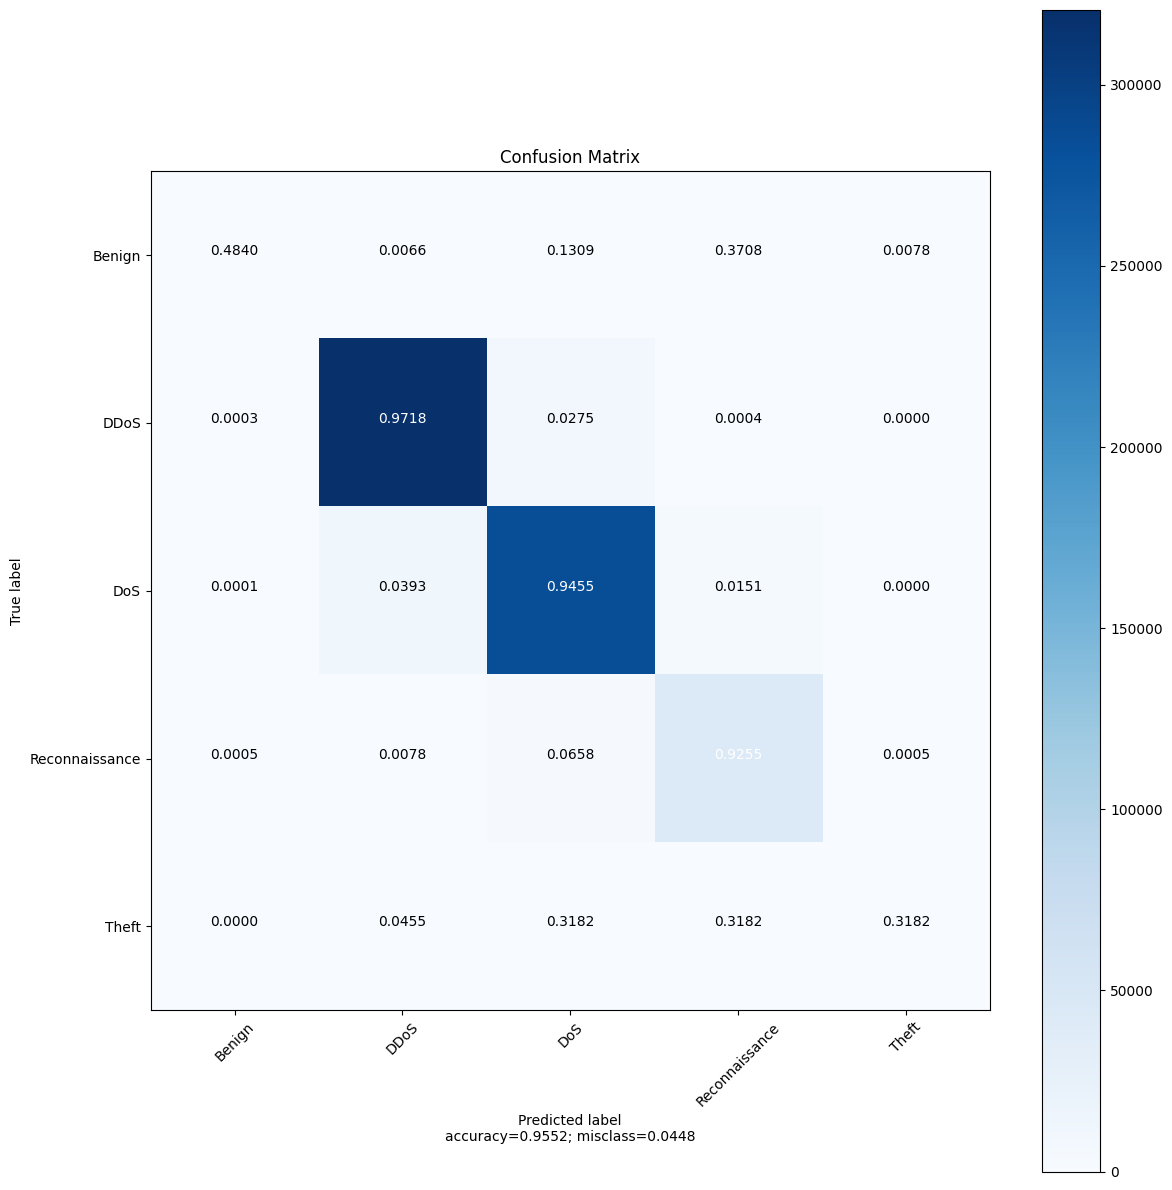

In [50]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(test_lbls, preds), 
                      normalize    = True,
                      target_names = np.unique(test_lbls),
                      title        = "Confusion Matrix")

In [51]:
test_lbls = list(test_lbls)
preds = list(preds)

In [52]:
from sklearn.metrics import classification_report
target_names = np.unique(test_lbls)
print(classification_report(test_lbls, preds, target_names=target_names, digits=4))

                precision    recall  f1-score   support

        Benign     0.8936    0.4840    0.6279      2430
          DDoS     0.9634    0.9718    0.9676    329974
           DoS     0.9578    0.9455    0.9516    300118
Reconnaissance     0.8864    0.9255    0.9055     47178
         Theft     0.2545    0.3182    0.2828        44

      accuracy                         0.9552    679744
     macro avg     0.7912    0.7290    0.7471    679744
  weighted avg     0.9553    0.9552    0.9550    679744



In [53]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.savefig("confusion_matrix.png")
    plt.show()

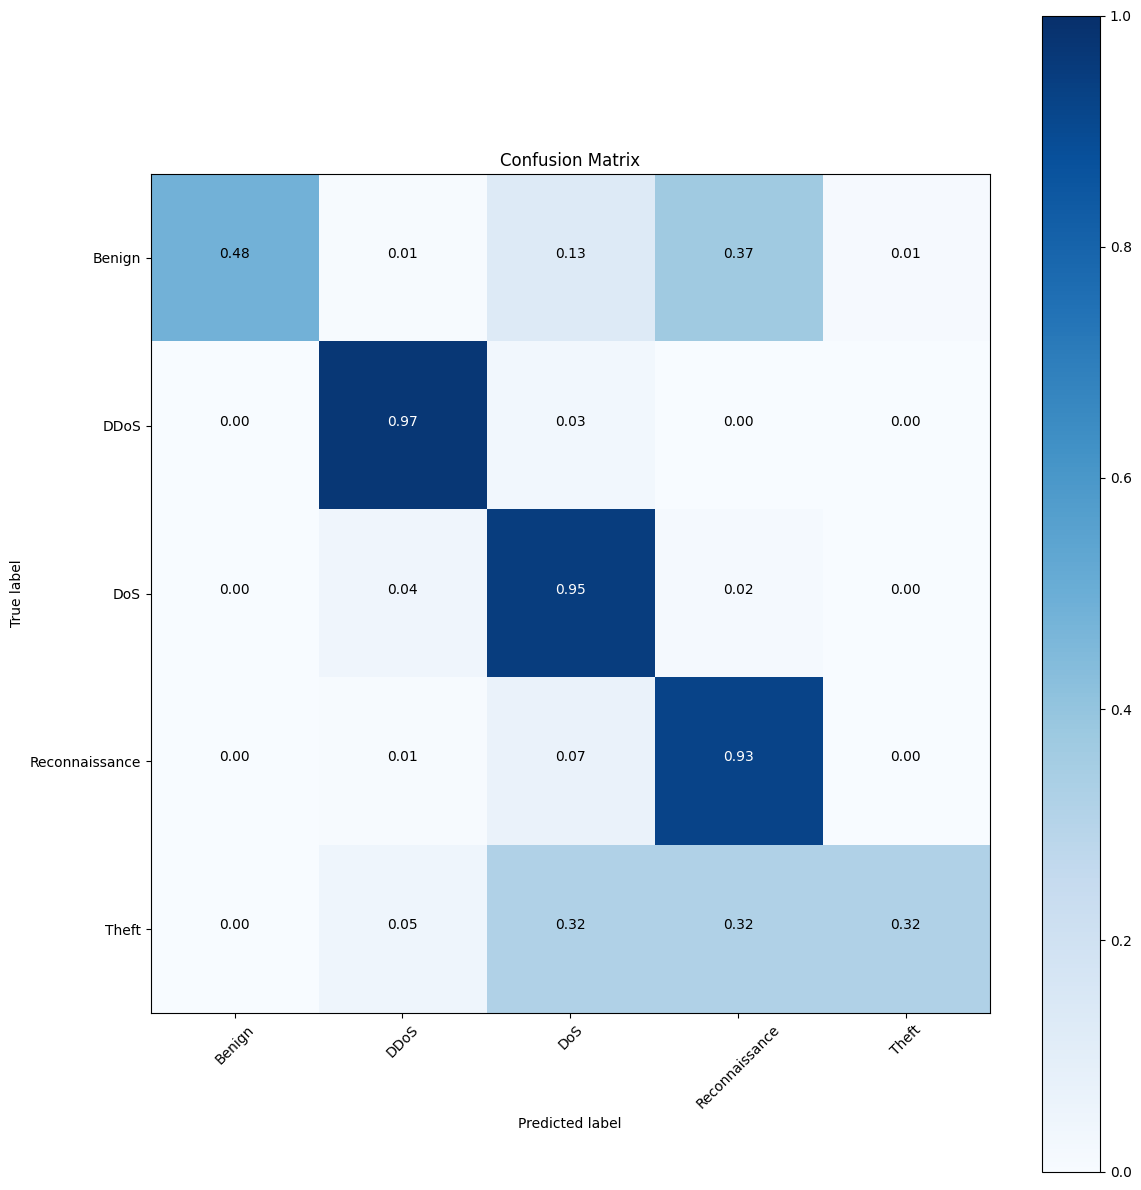

In [54]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(test_lbls, preds), 
                      normalize    = True,
                      target_names = np.unique(test_lbls),
                      title        = "Confusion Matrix")